In [1]:
import os 
from ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np
from ipsl_dataset import surface_variables,plev_variables
from hydra import compose, initialize
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import xarray as xr
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")


In [2]:
scratch = os.environ['SCRATCH']
work = os.environ['WORK']
checkpoint_folder = '20eg0mbx'
epoch = 10
with_soil_checkpoint_5_year = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/{checkpoint_folder}/checkpoints/24_month_epoch={epoch}.ckpt'
checkpoint_with_soil = torch.load(with_soil_checkpoint_5_year,map_location=torch.device('cpu'))
test = IPSL_DCPP('test',1)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)

soil_model = hydra.utils.instantiate(cfg.experiment.module,backbone=hydra.utils.instantiate(cfg.experiment.backbone,soil=True),dataset=test_dataloader.dataset)
soil_model.load_state_dict(checkpoint_with_soil['state_dict'])
trainer = pl.Trainer(fast_dev_run=12)
output = trainer.predict(soil_model, test_dataloader)



/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, 

Predicting DataLoader 0: 100%|██████████| 12/12 [02:03<00:00,  0.10it/s]


In [27]:
#get variables 
surface_var_name = 'cVeg'
plev_var_name = 'hur'
var_index = surface_variables.index(surface_var_name)
plev_var_index = plev_variables.index(plev_var_name)

#get shell
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)
land_mask = torch.tensor(np.load('data/land_mask.npy'))

In [28]:
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]


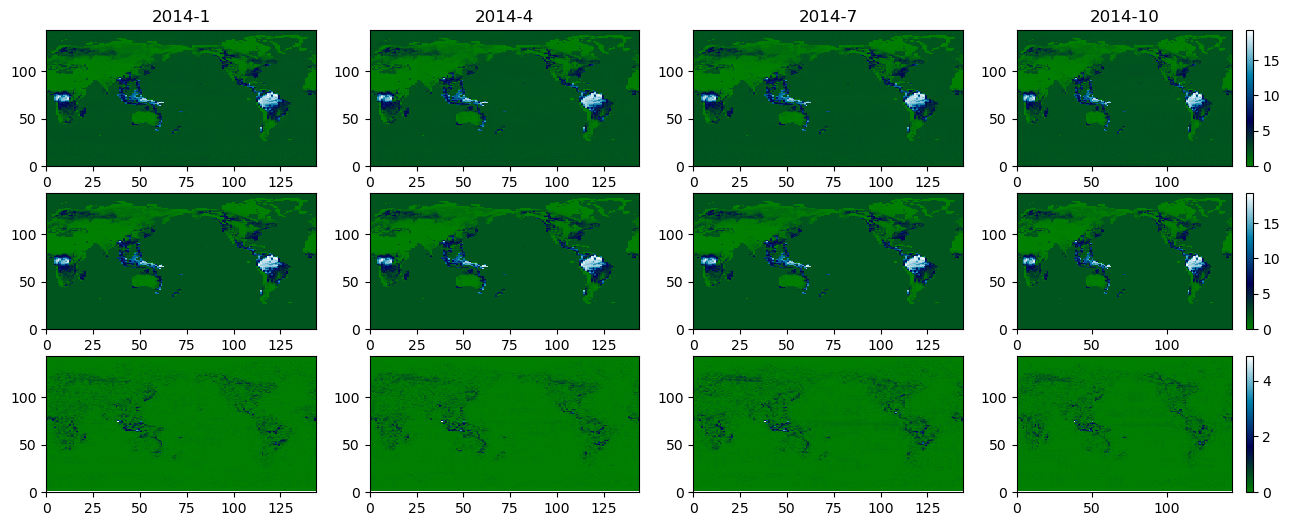

In [30]:
f, axs = plt.subplots(3, 4, figsize=(16, 6))
axs = axs.flatten()
#lat_range = 85:100
#lon_range = 25:50
subset_lats = lat_coeffs[:,:,:,85:110,:]
subset_lats = lat_coeffs
sub_shell = shell.isel(lat=slice(85,110),lon=slice(25,50))
sub_shell = shell
for index in range(0,len(output),3):
    pred = output[index][-2]
    batch = output[index][-1]
    predictions = pred['next_state_surface'].squeeze()[var_index][85:110,25:50]
    batch_data = batch['next_state_surface'].squeeze()[var_index][85:110,25:50]
    predictions = pred['next_state_surface'].squeeze()[var_index]
    batch_data = batch['next_state_surface'].squeeze()[var_index]
    #sub_shell[surface_var_name]['time'].data = next(iter(test_dataloader))['time'][0]
    #sub_shell[surface_var_name].data = predictions
    # xx = shell[surface_var_name].plot.pcolormesh(ax=axs[index//3],cmap='ocean',add_colorbar=False,add_labels=False)
    pred_ax = axs[index//3].pcolormesh(predictions,cmap='ocean',vmin=0,vmax=torch.max(batch_data))
    axs[index//3].set_title(f'2014-{index+1}')
    #sub_shell[surface_var_name].data = batch_data
    #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 4],cmap='ocean',add_colorbar=False,add_labels=False)
    batch_ax = axs[index//3+4].pcolormesh(batch_data ,cmap='ocean',vmin=0,vmax=torch.max(batch_data))

    
    rmse = torch.sqrt((predictions - batch_data).pow(2).mul(subset_lats))
    #sub_shell[surface_var_name].data = mse.squeeze()
    #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 8],cmap='ocean',vmax=1e7,vmin=0)
    rmse_ax = axs[(index//3) + 8].pcolormesh(rmse.squeeze(),cmap='ocean',vmin=0)
    axs[(index//3) + 8].set_xlabel('')
    axs[(index//3) + 8].set_title('')
    axs[(index//3) + 8].set_ylabel('')
f.colorbar(pred_ax, ax=axs[index//3],cmap='ocean',location='right')
f.colorbar(batch_ax, ax=axs[index//3+4],cmap='ocean',location='right')
f.colorbar(rmse_ax, ax=axs[index//3+8],cmap='ocean',location='right')

plt.show()

In [13]:
output[index][-2]['next_state_surface'].squeeze()[var_index].shape

torch.Size([143, 144])

In [53]:
axs

In [80]:
#PRINT ERROR MAPS 

lat_coeffs = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
mse_surface = (pred['next_state_surface'] - batch['next_state_surface']).pow(2)
# if mse_level.shape[-2] == 128:
#     mse_level = mse_level[..., 4:-4, 8:-8]
mse_surface = mse_surface.mul(lat_coeffs)

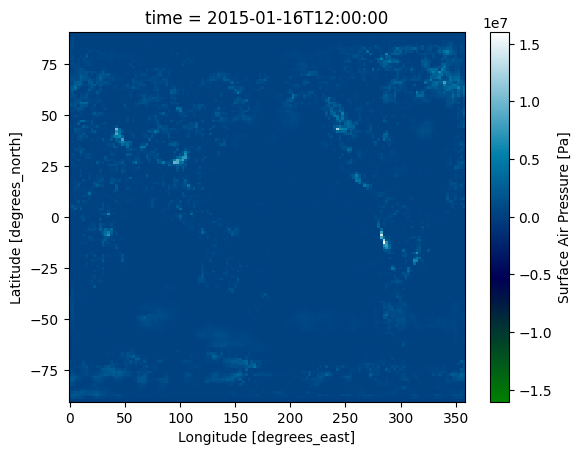

In [86]:
shell[surface_var_name].data = mse_surface.squeeze()[var_index]
shell[surface_var_name].plot.pcolormesh(cmap='ocean')

In [ ]:
import xarray as xr
import os, glob
import imageio

png_dir = '<your_directory>'
airtemps = xr.tutorial.open_dataset('air_temperature')

# Plots with variable (scaling) colorbar
for i in np.arange(25):
    plt.figure()
    plt.contourf(airtemps.air[i,:,:], levels = 25), plt.colorbar()
    plt.savefig(png_dir + 'air_temp_' + str(i) +'.png')    

max_temp = airtemps.air[:25,:,:].max()
min_temp = airtemps.air[:25,:,:].min()  

# Plots with Fixed colorbar    
for i in np.arange(25):
    plt.figure()
    plt.contourf(airtemps.air[i,:,:], levels = np.linspace(min_temp,max_temp,25)), plt.colorbar()
    plt.savefig(png_dir + 'fixed_cb_air_temp_' + str(i) +'.png')

variable_cb_images = glob.glob(png_dir + 'air*')
fixed_cb_images = glob.glob(png_dir + ('fix*'))  

var = [imageio.imread(file) for file in variable_cb_images]
fix = [imageio.imread(file) for file in fixed_cb_images]

imageio.mimsave(png_dir + '/movie_variable_cb.gif', var, fps = 10)
imageio.mimsave(png_dir + '/movie_fixed_cb.gif', fix, fps = 10)